# **Explicação detalhada do agrupamento Butina**

Butina clustering (J. Chem. Inf. Model. (1999), 39 (4), 747) foi desenvolvido para identificar clusters menores, mas homogêneos, com o pré-requisito de que, pelo menos, o centróide do cluster será mais semelhante do que um determinado limite a todas as outras moléculas no cluster.

# **Estas são as principais etapas dessa abordagem de agrupamento:**

### **1. Preparação de dados e codificação composta**
Para identificar semelhanças químicas, os compostos nos dados de entrada (dados como SMILES) serão codificados como impressões digitais moleculares, por exemplo, impressão digital RDK5, que é uma impressão digital baseada em subgráfico semelhante à bem conhecida impressão digital Daylight (que foi usada na publicação original).

### **2. Matriz de semelhança (ou distância) de Tanimoto**
A semelhança entre duas impressões digitais é calculada usando o coeficiente de Tanimoto.

A matriz com semelhanças de Tanimoto entre todos os pares possíveis de moléculas/impressões digitais é dita matriz de similaridade (**n * n**), onde n é o número de moléculas e apenas o triângulo superior da matriz é usado.

Da mesma forma, a matriz das distâncias pode ser calculada (1 - similaridade).

### **3. Agrupamento de moléculas: Centróides e esferas de exclusão**
As moléculas serão grupadas se tiverem uma distância máxima abaixo de um corte especificado do centróide do cluster, se a matriz de distância for usada ou se tiverem uma semelhança mínima acima do corte especificado, se a matriz de similaridade for usada.

- **Identificação de potenciais centroides de cluster**

  O centróide do cluster é a molécula dentro de um determinado cluster que tem o maior número de vizinhos.

  Então, conte os vizinhos: Para cada molécula, conte todas as moléculas com uma distância Tanimoto abaixo de um determinado limite.

  Em seguida, ordene as moléculas pelo número de vizinhos em ordem decrescente, de modo que os centróides potenciais do cluster, isto é, os compostos com o maior número de vizinhos, sejam colocados no topo do arquivo.

- **Agrupamento baseado nas esferas de exclusão**

  Começando com a primeira molécula (centróide) na lista classificada.
  
  Todas as moléculas com um índice de Tanimoto acima ou igual ao valor de corte usado para agrupamento tornam-se membros desse agrupamento (no caso de similaridade).

  Cada molécula que foi identificada como um membro do cluster dado é sinalizada e removida de outras comparações.

  Assim, as moléculas sinalizadas não podem se tornar outro centróide de cluster ou um membro de outro cluster. Esse processo é como colocar uma esfera de exclusão ao redor do cluster recém-formado.

  Uma vez que o primeiro composto na lista tenha encontrado todos os seus vizinhos, o primeiro composto disponível (ou seja, não sinalizado) no topo da lista torna-se o novo centróide do cluster.

  O mesmo processo é repetido para todas as outras moléculas não marcadas na lista.

  Moléculas que não foram sinalizadas até o final do processo de agrupamento tornam-se **singletons**.
  
  Observe que algumas moléculas designadas como singletons podem ter vizinhos no índice de similaridade de Tanimoto fornecido, mas esses vizinhos foram excluídos por um centróide de cluster mais forte.

# Agrupando moléculas com o algoritmo Butina

- Carga dos dados e cálculo de fingerprints

In [ ]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 28.1 MB/s eta 0:00:00


In [ ]:
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator

random.seed(1000)

In [ ]:
compound_df = pd.read_csv("EGFR_compounds_lipinski.csv", index_col=0)
print("df shape:", compound_df.shape)
compound_df.head()

df shape: (4635, 10)


,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.2891,True
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.9333,True
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.5969,True
3,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.0122,True
4,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.5726,True


In [ ]:
# Create molecules from SMILES and store in array
compounds = []
# .itertuples() returns a (index, column1, column2, ...) tuple per row
# we don't need index so we use _ instead
# note how we are slicing the dataframe to only the two columns we need now
for _, chembl_id, smiles in compound_df[["molecule_chembl_id", "smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), chembl_id))
compounds[:5]

[(<rdkit.Chem.rdchem.Mol at 0x7f9f4acc1c10>, 'CHEMBL63786'),
 (<rdkit.Chem.rdchem.Mol at 0x7f9f4acc1cf0>, 'CHEMBL35820'),
 (<rdkit.Chem.rdchem.Mol at 0x7f9f4acc1d60>, 'CHEMBL53711'),
 (<rdkit.Chem.rdchem.Mol at 0x7f9f4acc1dd0>, 'CHEMBL66031'),
 (<rdkit.Chem.rdchem.Mol at 0x7f9f4acc1e40>, 'CHEMBL53753')]

In [ ]:
# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, idx in compounds]

print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))


Number of compounds converted: 4635
Fingerprint length per compound: 2048


# Calculando a matriz de similaridade e distância de Tanimoto</b></font><br>

-  Com as fingerprints, passamos para a identificação dos potenciais centroides do cluster, definindo funções para calcular a similaridade e a matriz de distância de Tanimoto.

In [ ]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

[[Rdkit-discuss] BulkTanimotoSimilarity](https://sourceforge.net/p/rdkit/mailman/rdkit-discuss/thread/663770d4-b809-c599-e379-31f57380a1d0%40gmail.com/#msg36335970)

In [ ]:
# Example: Calculate single similarity of two fingerprints

sim = DataStructs.TanimotoSimilarity(fingerprints[0], fingerprints[1])
print(f"Tanimoto similarity: {sim:.2f}, distance: {1-sim:.2f}")

Tanimoto similarity: 0.73, distance: 0.27


In [ ]:
# Example: Calculate distance matrix (distance = 1-similarity)
tanimoto_distance_matrix(fingerprints)[0:5]

[0.26996197718631176,
 0.26538461538461533,
 0.40866873065015474,
 0.09345794392523366,
 0.31182795698924726]

Essa amostra é na verdade uma matriz de similaridade triangular em forma de lista

In [ ]:
n = len(fingerprints)

# Calculate number of elements in triangular matrix via n*(n-1)/2
elem_triangular_matr = (n * (n - 1)) / 2
print(
    f"Elements in the triangular matrix ({elem_triangular_matr:.0f}) ==",
    f"tanimoto_distance_matrix(fingerprints) ({len(tanimoto_distance_matrix(fingerprints))})",
)


Elements in the triangular matrix (10739295) == tanimoto_distance_matrix(fingerprints) (10739295)


# Agrupamento de moléculas (clustering): Identificando centróides e esferas de exclusão

In [ ]:
def cluster_fingerprints(fingerprints, cutoff=0.2):
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

- Agrupamos as moléculas com base em sua semelhança de fingerprints.

In [ ]:
clusters = cluster_fingerprints(fingerprints, cutoff=0.2)

# Numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)


total # clusters:  1128
# clusters with only 1 compound:  592
# clusters with >5 compounds:  185
# clusters with >25 compounds:  25
# clusters with >100 compounds:  2


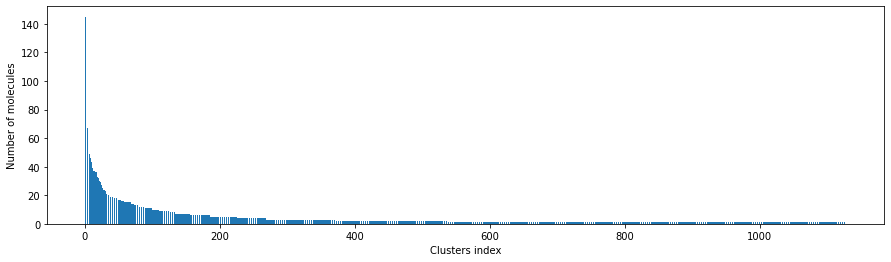

In [ ]:
# Plot of the size of the clusters
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Clusters index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5);


- Como escolher um ponto de corte razoável?

- Como o resultado do agrupamento depende do limite escolhido, vamos testar cinco agrupamentos com cutoff diferentes.

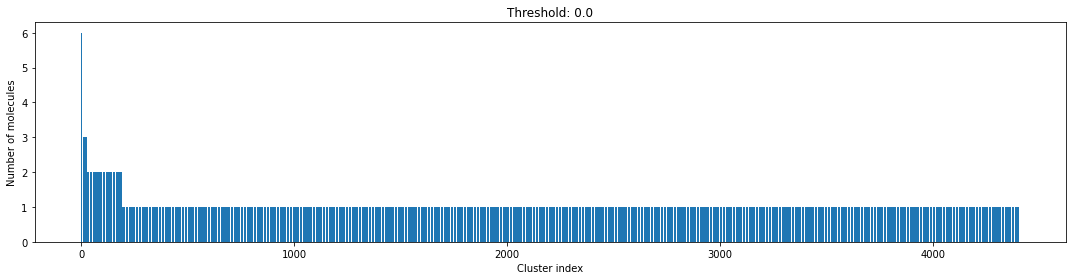

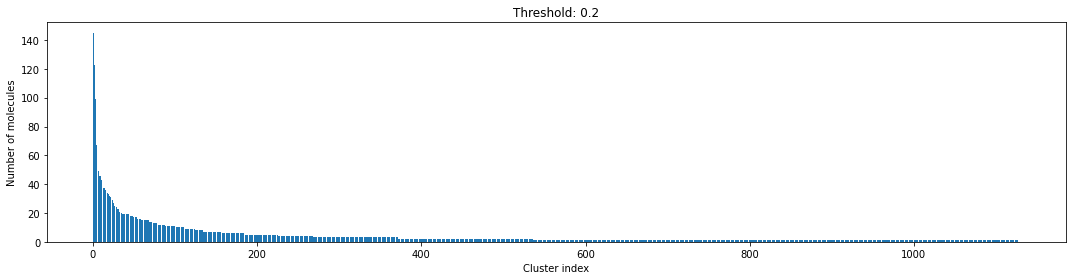

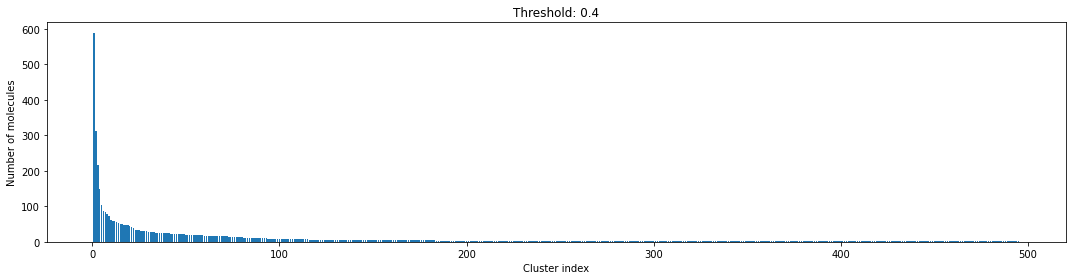

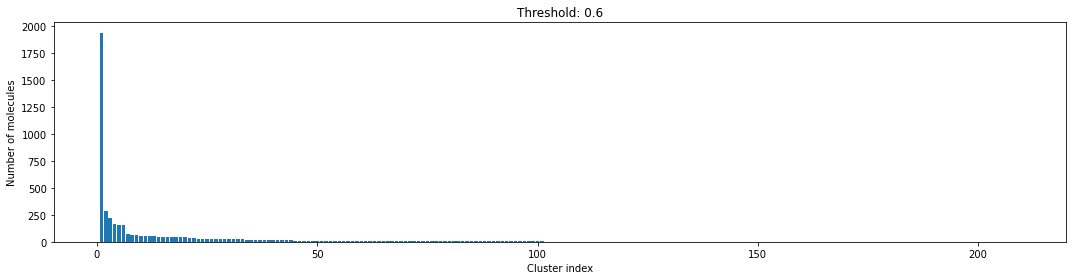

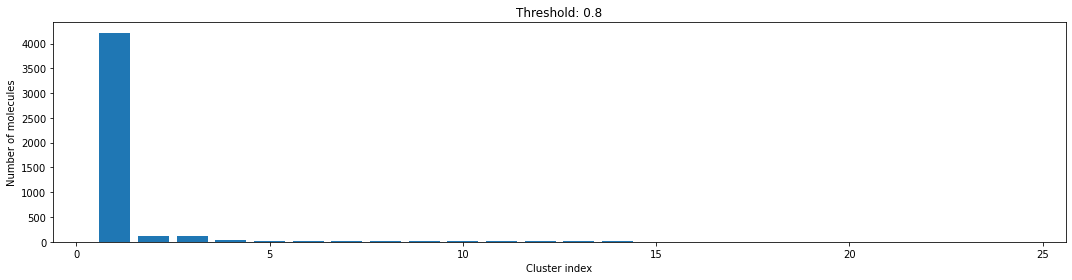

In [ ]:
for cutoff in np.arange(0.0, 1.0, 0.2):
    clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
    plt.tight_layout()

- Como se pode ver, quanto maior o ponto de corte, mais moléculas são consideradas semelhantes e, portanto, agrupadas em menos grupos. Quanto menor esse ponto, menores os clusters e “singletons” aparecem.

- *Quanto menor o cutoff, mais semelhantes os compostos devem ser para pertencer a um mesmo cluster.*

- Olhando para os gráficos acima, decidimos escolher um limite de distância de 0,2. Não há muitos singletons e os tamanhos dos clusters não têm uma distribuição extrema, mas suave.

Number of clusters: 1128 from 4635 molecules at distance cut-off 0.20
Number of molecules in largest cluster: 145
Similarity between two random points in same cluster: 0.82
Similarity between two random points in different cluster: 0.22



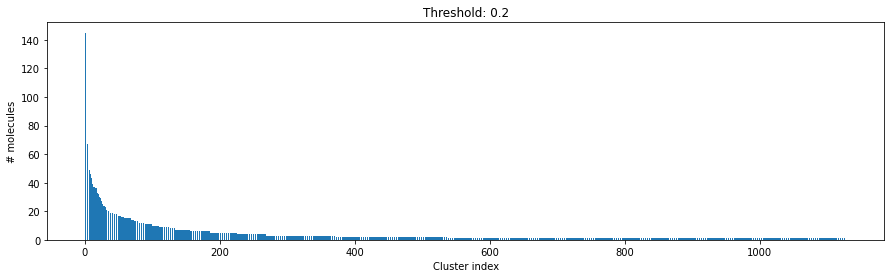

In [ ]:
cutoff = 0.2
clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)

# Plot the size of the clusters - save plot
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters])
ax.set_title(f"Threshold: {cutoff:3.1f}")

fig.savefig(
    f"cluster_dist_cutoff_{cutoff:4.2f}.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

print(f"Number of clusters: {len(clusters)} from {len(compounds)} molecules at distance cut-off {cutoff:.2f}")
print("Number of molecules in largest cluster:", len(clusters[0]))
print(f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][1]]):.2f}")
print(f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][0]]):.2f}")
print("")

- Classificando os clusters por tamanho e as moléculas em cada cluster por similaridade.

In [ ]:
# Sort the molecules within a cluster based on their similarity
# to the cluster center and sort the clusters based on their size
sorted_clusters = []
for cluster in clusters:
    if len(cluster) <= 1:
        continue  # Singletons
    # else:
    # Compute fingerprints for each cluster element
    sorted_fingerprints = [rdkit_gen.GetFingerprint(compounds[i][0]) for i in cluster]
    # Similarity of all cluster members to the cluster center
    similarities = DataStructs.BulkTanimotoSimilarity(
        sorted_fingerprints[0], sorted_fingerprints[1:]
    )
    # Add index of the molecule to its similarity (centroid excluded!)
    similarities = list(zip(similarities, cluster[1:]))
    # Sort in descending order by similarity
    similarities.sort(reverse=True)
    # Save cluster size and index of molecules in clusters_sort
    sorted_clusters.append((len(similarities), [i for _, i in similarities]))
    # Sort in descending order by cluster size
    sorted_clusters.sort(reverse=True)

- Salvamos o arquivo de clusters e moléculas, classificado, com os dados no ponto de corte escolhido para futura referência.

In [ ]:
np.savetxt("np_sorted_clusters.csv", sorted_clusters, delimiter =",",fmt ='% s')

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:1393: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.asarray(X)


In [ ]:
print(sorted_clusters[-4:-1])

[(1, [83]), (1, [56]), (1, [53])]


In [ ]:
print(sorted_clusters[29])

(22, [2489, 3435, 4331, 2088, 1709, 4471, 2025, 2682, 3215, 2485, 3837, 4479, 1777, 3662, 3809, 2139, 3742, 3864, 3709, 2296, 1151, 808])


# Análise dos tempos de execução

- No final podemos variar o tamanho do conjunto de dados e ver como o tempo de execução do clustering Butina muda.

In [ ]:
# Reuse old dataset
sampled_mols = compounds.copy()

- Podemos experimentar conjuntos de dados maiores, mas tamanhos de dados maiores que 10.000 já começam a consumir mais memória e tempo e é por isso que paramos por aí.

In [ ]:
# Helper function for time computation
def measure_runtime(sampled_mols):
    start_time = time.time()
    sampled_fingerprints = [rdkit_gen.GetFingerprint(m) for m, idx in sampled_mols]
    # Run the clustering with the dataset
    sampled_clusters = cluster_fingerprints(sampled_fingerprints, cutoff=0.3)
    return time.time() - start_time

In [ ]:
len(sampled_mols)


4635

In [ ]:
sample_sizes = [100, 500, 1000, 2000, 4000]
runtimes = []
# Take random samples with replacement
for size in sample_sizes:
    time_taken = measure_runtime(random.sample(sampled_mols, size))
    print(f"Dataset size {size}, time {time_taken:4.2f} seconds")
    runtimes.append(time_taken)

Dataset size 100, time 0.13 seconds
Dataset size 500, time 0.61 seconds
Dataset size 1000, time 1.15 seconds
Dataset size 2000, time 2.12 seconds
Dataset size 4000, time 6.20 seconds


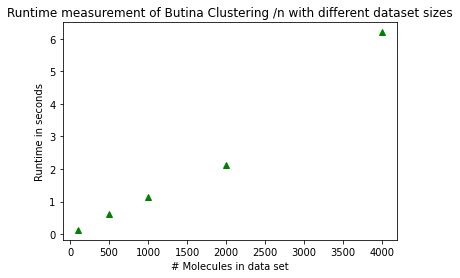

In [ ]:
fig, ax = plt.subplots()
ax.set_title("Runtime measurement of Butina Clustering /n with different dataset sizes")
ax.set_xlabel("# Molecules in data set")
ax.set_ylabel("Runtime in seconds")
ax.plot(sample_sizes, runtimes, "g^");

- Observamos que o tempo de execução não é exatamente proporcional ao tamanho da amostra! Ele cresce mais rápido!